In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100) # показывать больше колонок

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip3 freeze > requirements.txt

In [5]:
def IQR_outlier(column, verbose=True):
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    count_outliers = len(data[data[column] > high])+len(data[data[column] < low])
    if verbose:
        print('Для признака', column, ':')
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return print('Выбросов, согласно IQR: {} | {:2.2%}'.format(count_outliers, count_outliers
                                                               /len(data)))


def calc_and_plot_roc(y_valid, y_pred_proba):
    '''
    Функция для построения ROC кривой и подсчёта значения площади под кривой AUC
    '''
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

### Загрузка и первичный осмотр данных

In [465]:
# загружаем наши датасеты
df_sample_submission = pd.read_csv('sample_submission.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

display(df_train.head(2))
display(df_test.head(2))
display(df_sample_submission.head(2))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


,client_id,default
0,74835,0
1,17527,0


In [466]:
#Проверим датасет df_train на наличие дубликатов:
if len(df_train)>len(df_train.drop_duplicates()):
    print('Дубликаты есть')
    display(df_train[df_train.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


In [467]:
#Проверим датасет df_test на наличие дубликатов:
if len(df_test)>len(df_test.drop_duplicates()):
    print('Дубликаты есть')
    display(df_test[df_test.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


In [468]:
print("Размер датасета df_sample_submission:", df_sample_submission.shape)
print()
df_sample_submission.info()

Размер датасета df_sample_submission: (36349, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [469]:
print("Размер датасета df_train:", df_train.shape)
print()
df_train.info()

Размер датасета df_train: (73799, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  f

In [470]:
print("Размер датасета df_test:", df_test.shape)
print()
df_test.info()

Размер датасета df_test: (36349, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  fi

#### Описание переменных:
- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заемщика
- **age** - возраст заемщика
- **car** - флаг наличия автомобиля
- **car_type** - флаг автомобиля иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия “хорошей” работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заемщика
- **foreign_passport** - наличие загранпаспорта
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **score_bki** - скоринговый балл по данным из БКИ
- **region_rating** - рейтинг региона
- **app_date** - дата подачи заявки
- **default** - флаг дефолта по кредиту

### Изучение прогнозируемой переменной

In [471]:
df_train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

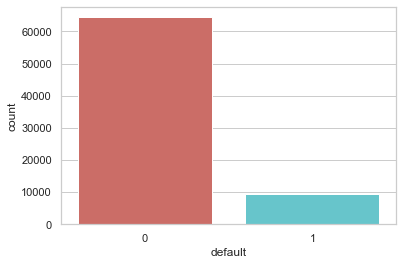

<Figure size 432x288 with 0 Axes>

In [472]:
sns.countplot(x = 'default', data = df_train, palette = 'hls')
plt.show()
plt.savefig('count_plot')

In [14]:
count_no_default = len(df_train[df_train['default']==0])
count_default = len(df_train[df_train['default']==1])
pct_of_no_def = count_no_default/(count_no_default+count_default)
print("Процент не дефолтных клиентов:", round(pct_of_no_def*100,2))
pct_of_def = count_default/(count_no_default+count_default)
print("Процент дефолтных клиентов:", round(pct_of_def*100,2))

Процент не дефолтных клиентов: 87.3
Процент дефолтных клиентов: 12.7


Наши классы не сбалансированы, и соотношение не дефолтных клиентов к дефолтным составляет 87:13. После создания наших обучающих данных я увеличу частоту выборки дефолтных клиентов, используя алгоритм SMOTE (синтетическая техника дублирования примеров миноритарного класса).  

Прежде чем мы перейдём к балансировке, давайте проведём дополнительное исследование.

In [15]:
df_train.groupby('default').mean()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
default,,,,,,,,,,,,
0,55614.538082,39.390504,0.240877,0.171031,-1.938048,1.933134,57.169044,1.558477,2.474816,41799.713288,1.679405,2.806106
1,51861.805484,38.525395,0.515472,0.122706,-1.675637,2.462335,53.677977,1.692595,2.643833,36288.113316,2.104033,2.486022


#### Наблюдения:
- Средний возраст клиентов банка, с одобренным кредитом, выше, чем тех, кому отказали.
- Странно, что score_bki ниже у клиентов с одобренным кредитом. И сам вид скорингового балла странный, но предполаю, что он каким-то образом уже нормализован. Для банков балл, рассчитанный Бюро, часто не является главным критерием при принятии решения о выдаче кредита. 
- Средняя зарплата ниже у дефолтных клиентов.
- Чем больше в прошлом отказов decline_app_cnt, тем чаще отказывают в кредите


Мы можем вычислить средние категориальные значения для других категориальных переменных, вроде образования и региона, чтобы получить более точное представление о данных.

In [17]:
df_train.groupby('education').mean()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
education,,,,,,,,,,,,,
ACD,57283.958763,40.149485,0.185567,0.469072,-2.061176,1.865979,64.278351,1.649485,2.613402,82966.634021,1.505155,3.195876,0.041237
GRD,56460.425423,38.053970,0.231629,0.247935,-1.919203,2.153135,58.470362,1.569698,2.485769,54663.948941,1.568329,2.938883,0.090092
PGR,55854.376293,38.252188,0.195704,0.302307,-1.971700,2.181384,60.723946,1.573588,2.487669,77548.206046,1.447096,3.080350,0.064439
SCH,53699.882450,41.143850,0.287005,0.108003,-1.905156,1.960113,55.190685,1.571976,2.491431,31960.275039,1.832578,2.667756,0.150592
UGR,57721.017522,34.862062,0.353606,0.169214,-1.855461,1.782090,57.876936,1.600856,2.537490,39391.796251,1.778015,2.687042,0.131520


Чем выше образование, выше доход, тем меньше отказов в кредите.

In [18]:
df_train.groupby('region_rating').mean()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,default
region_rating,,,,,,,,,,,,
20,56486.252427,41.805825,0.407767,0.271845,-1.955371,2.029126,2.019417,3.000000,31212.956311,1.878641,2.616505,0.213592
30,53487.776667,41.496667,0.410000,0.190000,-1.912680,1.823333,1.523333,2.336667,29108.333333,1.916667,2.516667,0.190000
40,54467.229567,40.609046,0.315041,0.146587,-1.893128,1.962584,1.505363,2.371331,33620.752640,1.726698,2.715806,0.169702
50,55258.007521,39.840606,0.281583,0.142971,-1.915618,1.983650,1.478400,2.369291,35024.432765,1.798895,2.714748,0.136141
60,55136.856983,39.103204,0.287776,0.157201,-1.914345,2.017916,1.569705,2.461586,37535.466812,1.849580,2.728523,0.128834
70,54806.179384,37.419100,0.253267,0.190192,-1.857061,2.145669,1.450073,2.557187,55841.984998,1.600903,2.714793,0.092434
80,55753.090243,37.695353,0.209957,0.231232,-1.901899,1.980905,1.951434,2.942890,61040.945854,1.484175,3.027553,0.073154


Чем выше рейтинг региона, выше заработная плата, тем меньше отказов в кредите.

In [22]:
df_train.groupby('good_work').mean()

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
good_work,,,,,,,,,,,,
0,55070.772903,39.670501,0.285527,-1.906112,1.994597,56.301963,1.576359,2.498897,40634.009784,1.760312,2.740419,0.133409
1,55478.260498,37.306188,0.226231,-1.897694,2.029419,58.871723,1.571206,2.483031,43458.649273,1.596680,2.892267,0.094502


Чем лучше работа у клиента, выше заработная плата, тем меньше отказов в кредите.

### Визуализации

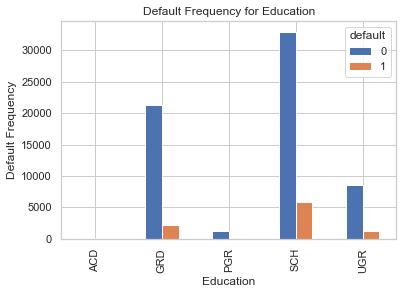

In [23]:
# Соотношение дефолт/не дефолт для разного уровня образования
pd.crosstab(df_train.education,df_train.default).plot(kind='bar')
plt.title('Default Frequency for Education')
plt.xlabel('Education')
plt.ylabel('Default Frequency')
plt.savefig('def_fre_edu')

Образование выглядит хорошим фактором для прогноза итоговой переменной.

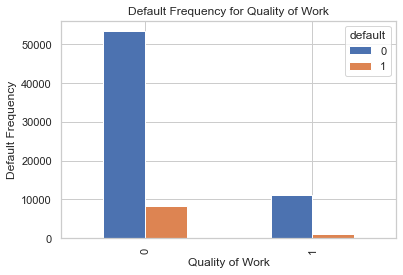

In [24]:
# Соотношение дефолт/не дефолт для разного уровня работы
pd.crosstab(df_train.good_work,df_train.default).plot(kind='bar')
plt.title('Default Frequency for Quality of Work')
plt.xlabel('Quality of Work')
plt.ylabel('Default Frequency')
plt.savefig('def_fre_gwork')

Наличие хорошей работы - тоже.

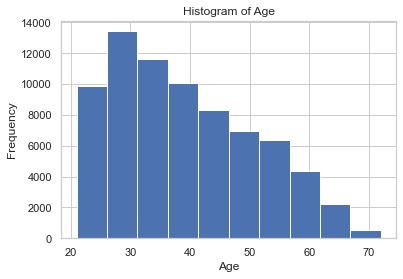

In [25]:
# Посмотрим на распределение клиентов по возрастам
df_train.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Большинство клиентов банка в этом наборе данных находятся в возрасте от 21 до 45 лет.

### Обработка данных

In [473]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, 
# по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [474]:
print("Размер датасета data:", data.shape)
print()
data.head(2)

Размер датасета data: (110148, 20)



,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0


In [475]:
display (data.info())
display (data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [476]:
# Посмотрим на количество пропусков у признаков
data.isnull().sum() 

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [477]:
# заполняем пропуски в столбце 'education' модой:
data['education'] = data['education'].fillna(data['education'].mode()[0])

In [478]:
#бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']

#числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

#### Признак app_date

In [479]:
# переведём из object в datetime
data['app_date'] = pd.to_datetime(data['app_date'])

# посмотрим, есть ли отличия по датам обращения с заявкой по годам и месяцам
data_1 = data.copy()
data_1['year'] = data_1['app_date'].dt.year
data_1['month'] = data_1['app_date'].apply(lambda x: x.strftime('%B')) # не применяла dt.month специально
print(data_1['year'].value_counts())
print()
print(data_1['month'].value_counts())

2014    110148
Name: year, dtype: int64

March       31597
February    27097
April       26266
January     25188
Name: month, dtype: int64


Имеет смысл перевести признак **app_date** в признак **month_2014** и применить к нему **get.dummies** , признак **app_date** и **month_2014** потом можно удалить 

In [480]:
data['month_2014'] = data['app_date'].apply(lambda x: x.strftime('%B'))
data_month_2014 = pd.get_dummies(data['month_2014'], dummy_na=False).astype('int64')
data = pd.concat([data,data_month_2014], axis=1)
data.drop(['app_date', 'month_2014'], axis = 1, inplace=True)
# Посмотрим, что получилось
data.head(2)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,April,February,January,March
0,74835,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0,0,0,0,1
1,17527,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0,0,0,1,0


#### Числовые признаки

In [481]:
# логарифмируем числовые переменные, чтобы сгладить разницу в размерности и уменьшить выбросы
# поскольку признак score_bki принимает отрицательные значения, мы его не трогаем
for col in list((Counter(num_cols) - Counter(['score_bki'])).elements()):
    data[col] = data[col].apply(lambda x: np.log(x + 1))

<AxesSubplot:>

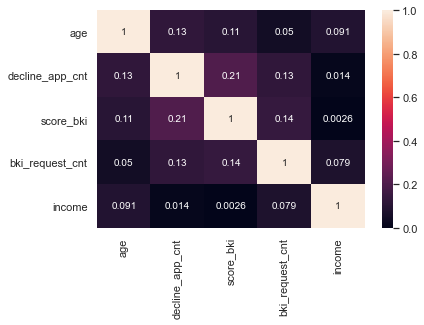

In [482]:
# посмотрим на корреляцию между собой числовых переменных
sns.heatmap(data[num_cols].corr().abs(), annot=True, vmin=0, vmax=1)

<AxesSubplot:>

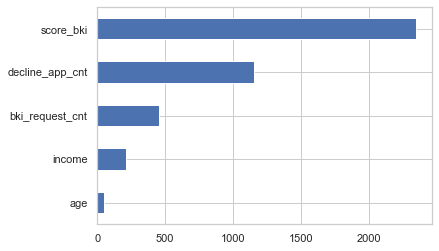

In [483]:
# для оценки значимости числовых переменных будем использовать функцию f_classif 
imp_num = pd.Series(f_classif(data[(data['sample']== 1)][num_cols], data[(data['sample']== 1)]['default']
                             )[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Чем значение **f-статистики** выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели. В данном случае, это **score_bki**

<Figure size 432x288 with 0 Axes>

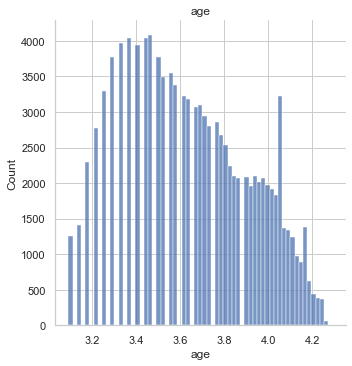

<Figure size 432x288 with 0 Axes>

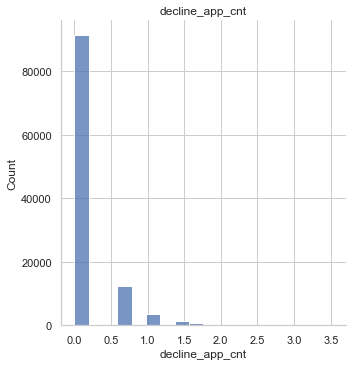

<Figure size 432x288 with 0 Axes>

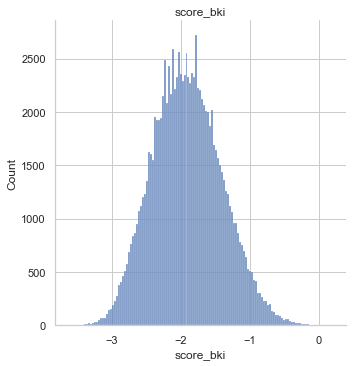

<Figure size 432x288 with 0 Axes>

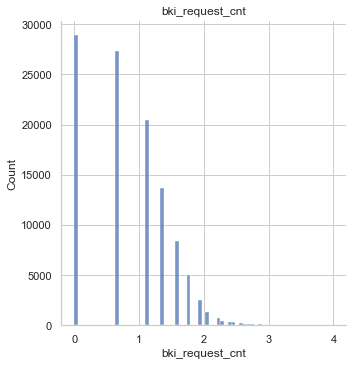

<Figure size 432x288 with 0 Axes>

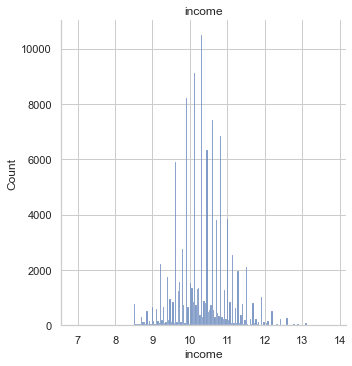

In [484]:
# посмотрим распределение числовых параметров
for col in num_cols:
    plt.figure()
    sns.displot(data[col], kde = False, rug=False)
    # sns.displot(data[col][data[col] > 0].dropna(), kde = False, rug=False)
    plt.title(col)
    plt.show()

In [485]:
# Посмотрим сколько выбросов осталось в числовых признаках после логарифмирования:
for col in num_cols:
    IQR_outlier(col, verbose=True)
    print()

Для признака age :
25-й перцентиль: 3.4339872044851463 75-й перцентиль: 3.8918202981106265, IQR: 0.4578330936254802,  Границы выбросов: [2.7472375640469258, 4.5785699385488465].
Выбросов, согласно IQR: 0 | 0.00%

Для признака decline_app_cnt :
25-й перцентиль: 0.0 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Выбросов, согласно IQR: 18677 | 16.96%

Для признака score_bki :
25-й перцентиль: -2.2604336700000003 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Выбросов, согласно IQR: 518 | 0.47%

Для признака bki_request_cnt :
25-й перцентиль: 0.0 75-й перцентиль: 1.3862943611198906, IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Выбросов, согласно IQR: 15 | 0.01%

Для признака income :
25-й перцентиль: 9.90353755128617 75-й перцентиль: 10.778977123006351, IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Выбросов, согласно IQR: 2

Корреляция между числовыми переменными низкая, это значит, что для нашей модели они все подходят
#### Итог анализа выбросов:
Вроде бы кажется, что хуже всего обстоит дело с выбросами у признака **decline_app_cnt**, но суть в том, что подавляющее число клиентов, а именно 83.04 %, не имели в прошлом отказов, и поэтому все значения отличные от нуля попадают в выбросы. Оставим пока все как есть, позднее будем использовать **RobustScaler** для стандартизации наших числовых признаков, чтобы уменьшить влияние выбросов.

### Бинарные признаки

In [486]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [487]:
data.sample(2)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,April,February,January,March
95830,9916,SCH,1,3.737670,0,0,0.0,0,-2.529219,0.000000,80,2,3,10.434145,1,4,0,1,0,0,0,1,0
93277,82419,GRD,1,3.610918,0,0,0.0,0,-2.042143,1.609438,50,2,3,11.350418,4,3,0,1,0,0,0,0,1


### Kатегориальные переменные

In [488]:
# Для категориальных признаков мы будем использовать OneHotEncoder
encoder = OneHotEncoder(sparse = False)
X_cat = encoder.fit_transform(data[cat_cols].values)

In [489]:
list_of_cols = encoder.get_feature_names(cat_cols).tolist()
X_cat_column = pd.DataFrame(X_cat, columns = list_of_cols)
data = pd.concat([data,X_cat_column],axis = 1)
data.head(2)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,April,February,January,March,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,work_address_1,work_address_2,work_address_3,home_address_1,home_address_2,home_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80
0,74835,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,17527,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [490]:
# Удаляем первоначальные категориальные столбцы, которые мы уже обработали с OneHotEncoder
data.drop(cat_cols, axis = 1, inplace=True)

### Посмотрим корреляцию признаков после предварительной обработки в датасете df_train

In [491]:
# Сформируем список признаков, которые исключаем из корреляционного анализа
columns_to_drop = ['client_id', 'sample']

<AxesSubplot:>

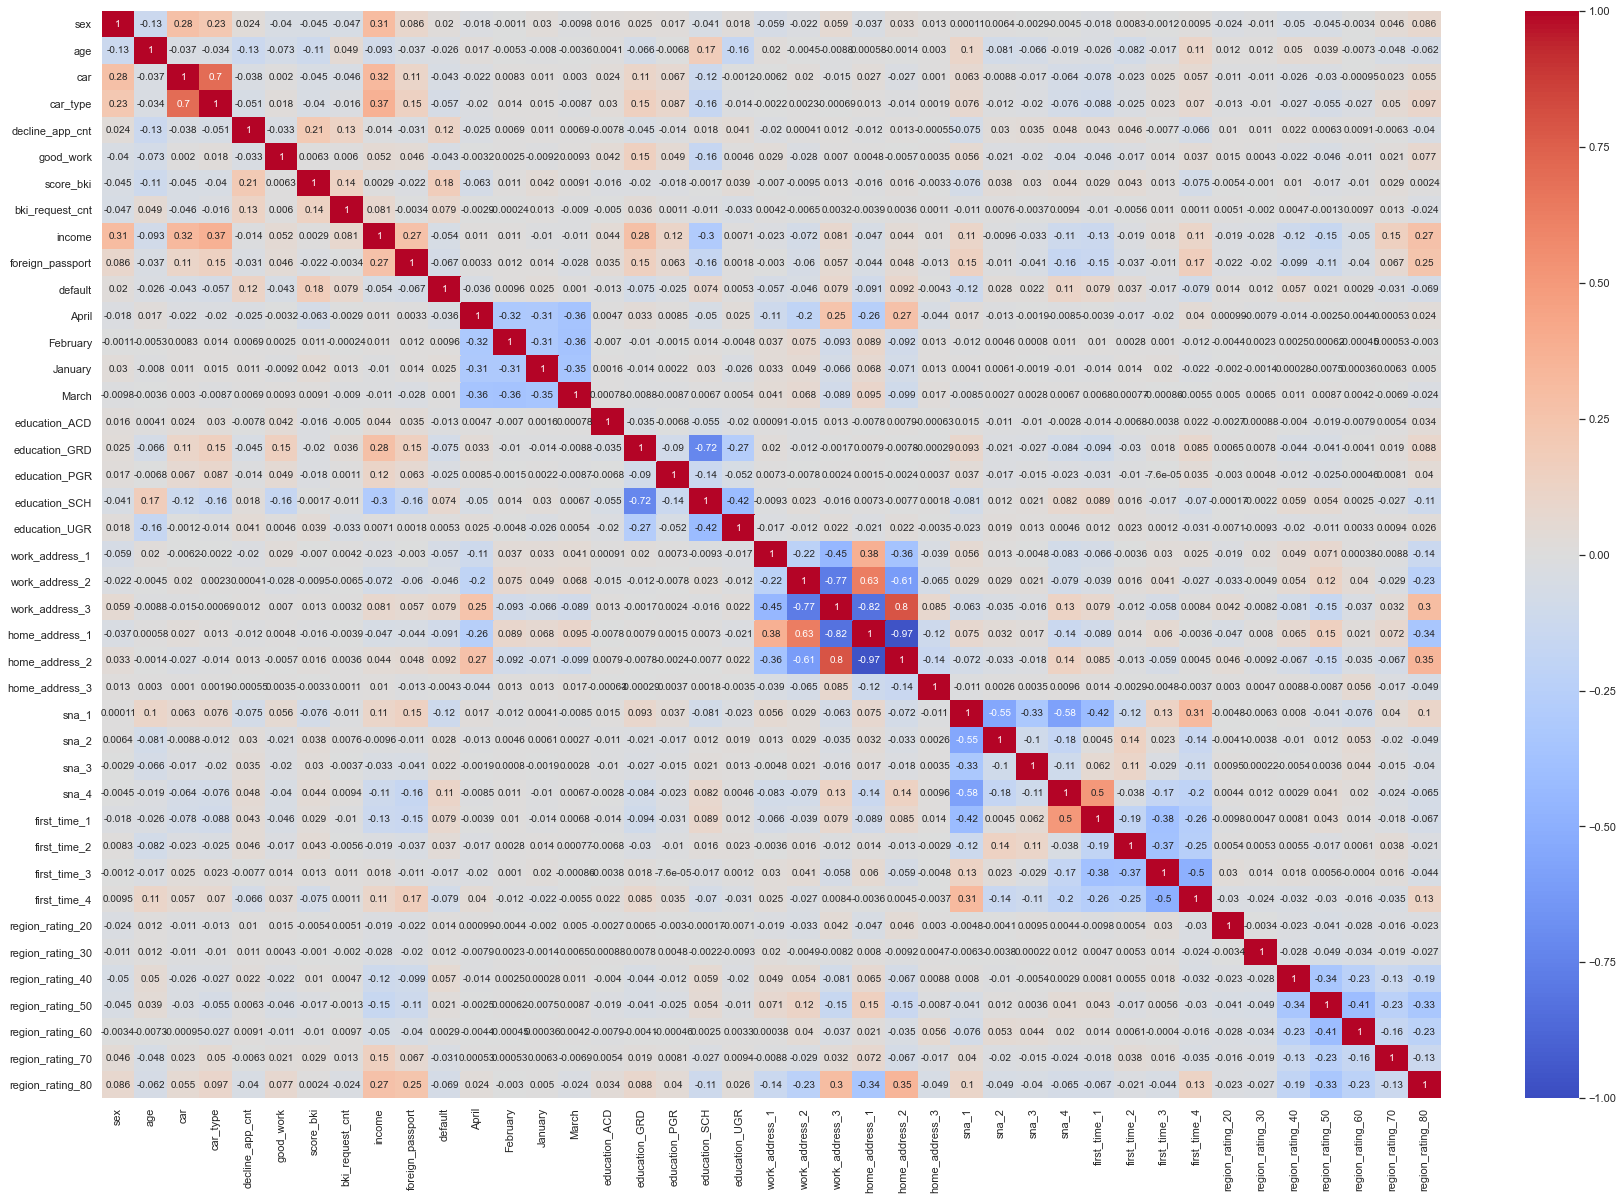

In [492]:
plt.figure(figsize=(30, 20))
data_corr = data.copy()

sns.heatmap(data_corr[data_corr['sample']== 1].drop(
    columns_to_drop, axis=1).corr(),annot=True,fmt='.2g', 
            vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Здесь видим, что некоторые категориальные признаки сильно коррелируют между собой

In [493]:
# Построим таблицу корреляции признаков с нашей искомой переменной default
data[data['sample']== 1].corr().default.sort_values(ascending=False).to_frame()

,default
default,1.000000
score_bki,0.175369
decline_app_cnt,0.124027
sna_4,0.110448
home_address_2,0.091869
first_time_1,0.079187
work_address_3,0.078609
bki_request_cnt,0.078501
education_SCH,0.074455
region_rating_40,0.056597


<AxesSubplot:>

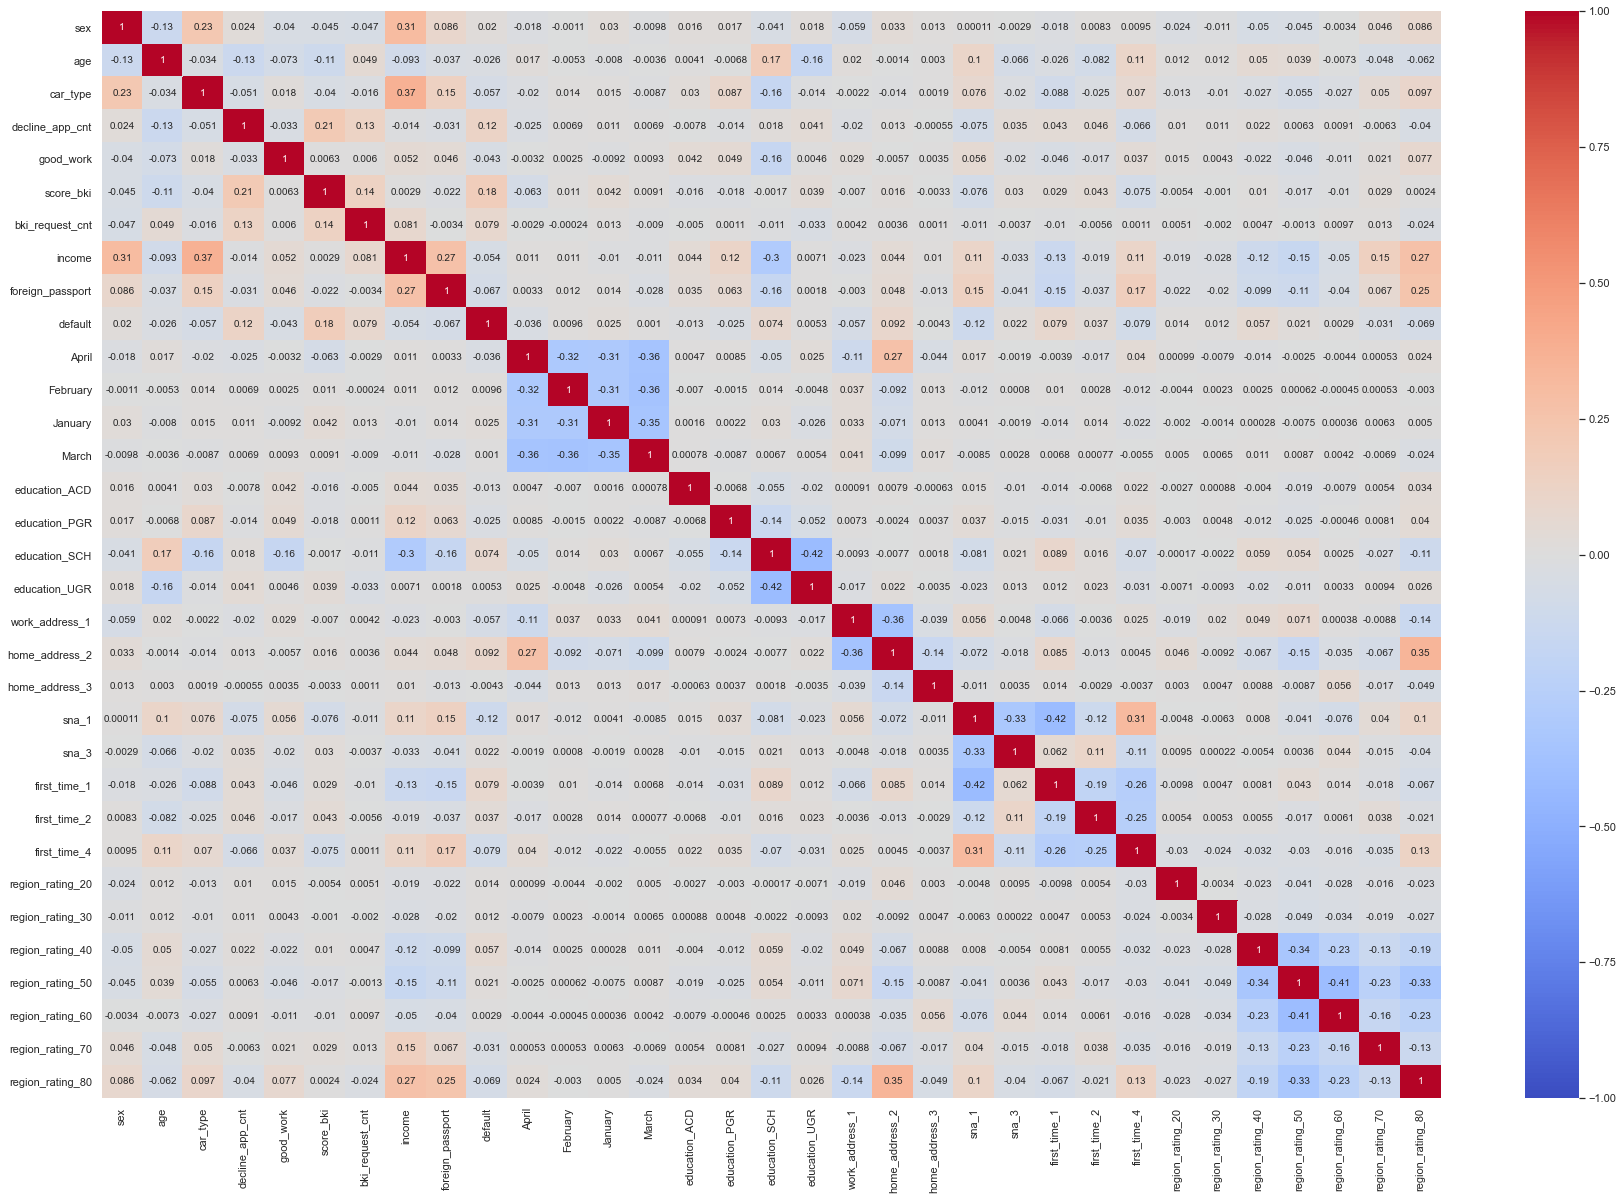

In [494]:
# удалим сильно коррелирующие между собой признаки (один из двух, который имеет меньшую корреляцию с default)
data.drop(['home_address_1', 'education_GRD', 'work_address_3', 'work_address_2','car', 'sna_4', 
             'sna_2', 'first_time_3'], axis = 1, inplace=True)
plt.figure(figsize=(30, 20))
data_corr = data.copy()

sns.heatmap(data_corr[data_corr['sample']== 1].drop(
    columns_to_drop, axis=1).corr(),annot=True,fmt='.2g', 
            vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [495]:
# client_id - уникален, но ни на что не влияет, и мы не будем использовать его для обучения модели 
# можно было сделать его индексами датафрейма (data = data.set_index('client_id')), но 
# при балансировке данных типа SMOTE произойдет переиндексация, поэтому просто удалим его
data.drop(['client_id'], axis = 1, inplace=True)

#### Наши финальные колонки будут:

In [496]:
data.columns.values

array(['sex', 'age', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'income', 'foreign_passport',
       'sample', 'default', 'April', 'February', 'January', 'March',
       'education_ACD', 'education_PGR', 'education_SCH', 'education_UGR',
       'work_address_1', 'home_address_2', 'home_address_3', 'sna_1',
       'sna_3', 'first_time_1', 'first_time_2', 'first_time_4',
       'region_rating_20', 'region_rating_30', 'region_rating_40',
       'region_rating_50', 'region_rating_60', 'region_rating_70',
       'region_rating_80'], dtype=object)


Разделяем датасет **data** обратно на **df_train** и **df_test**

In [784]:
df_train = data.query('sample == 1').drop(['sample'], axis=1)
df_test = data.query('sample == 0').drop(['sample', 'default'], axis=1)

In [785]:
#Нормализация численных данных
# Для тестовой выборки 
scaler_test = RobustScaler()
# Для обучающей выборки
for column in num_cols:
    df_test[column] = scaler_test.fit_transform(np.array(df_test[column].values).reshape(-1, 1))

In [786]:
X = df_train.loc[:, df_train.columns != 'default']
y = df_train['default'].values

Сейчас будем экспериментировать с нашими данными, делать Over-sampling, Under-sampling, RFE**, каждый раз искать **оптимальные гиперпараметры** для **LogisticRegression**, строить **ROC-кривую** и смотреть улучшило ли каждое преобразование нашу модель

### 1. Поиск оптимальных гиперпараметров, построение ROC-кривой

In [622]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [623]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((59039, 32), (14760, 32), (59039,), (14760,))

In [624]:
#Нормализация численных данных
scaler = RobustScaler()
# Для обучающей выборки
for column in num_cols:
    X_train[column] = scaler.fit_transform(np.array(X_train[column].values).reshape(-1, 1))
# Для валидационной выборки 
scaler_v = RobustScaler()
for column in num_cols:
    X_valid[column] = scaler_v.fit_transform(np.array(X_valid[column].values).reshape(-1, 1))

In [538]:
# Готовим данные для анализа оптимальных параметров настройки модели для решения задачи
random_seed = 42
C = np.logspace(-2, 1, 10)
iter_ = 1000
epsilon_stop = 1e-3
 
param_grid = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'],
     'class_weight':['none', 'balanced'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [209]:
model = LogisticRegression(random_state=random_seed)

In [210]:
# Обучаем модель
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
    print(f'  {param_name} = {best_params[param_name]}')

Лучшие значения параметров:
  C = 10.0
  class_weight = balanced
  dual = False
  fit_intercept = True
  intercept_scaling = 1
  l1_ratio = None
  max_iter = 1000
  multi_class = auto
  n_jobs = None
  penalty = l2
  random_state = 42
  solver = sag
  tol = 0.001
  verbose = 0
  warm_start = False


In [625]:
#Обучаем модель
from sklearn.linear_model import LogisticRegression 
logreg_0 = LogisticRegression(solver='sag', max_iter=1000, class_weight='balanced', C = 10, 
                            tol = 0.001, random_state = 42, penalty='l2')
logreg_0.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='sag', tol=0.001)

In [626]:
y_pred = logreg_0.predict(X_valid)

In [628]:
#Построение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
(tn, fp, fn, tp)

(8756, 4115, 606, 1283)

In [629]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_valid, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     12871
           1       0.24      0.68      0.35      1889

    accuracy                           0.68     14760
   macro avg       0.59      0.68      0.57     14760
weighted avg       0.85      0.68      0.73     14760



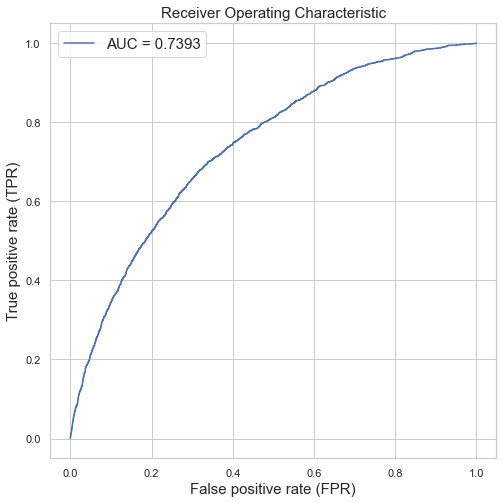

In [630]:
# Отрисовать ROC кривую
y_pred_proba = logreg_0.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba[:, 1])

### 2. Over-Sampling при помощи SMOTE, поиск оптимальных гиперпараметров, построение ROC-кривой

In [691]:
# Сбалансируем данные для обучения с помощью SMOTE

os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['default'])
# Мы можем проверить размеры наших данных
print("Длина oversampled данных составляет ",len(os_data_X))
print("Число отсутствующих дефолтов в oversampled данных ",len(os_data_y[os_data_y['default']==0]))
print("Число дефолтов ",len(os_data_y[os_data_y['default']==1]))
print("Доля данных без дефолтов в данных с oversampled выборкой составляет "
      ,len(os_data_y[os_data_y['default']==0])/len(os_data_X))
print("Доля данных с дефолтами в данных с oversampled выборкой составляет "
      ,len(os_data_y[os_data_y['default']==1])/len(os_data_X))

Длина oversampled данных составляет  103112
Число отсутствующих дефолтов в oversampled данных  51556
Число дефолтов  51556
Доля данных без дефолтов в данных с oversampled выборкой составляет  0.5
Доля данных с дефолтами в данных с oversampled выборкой составляет  0.5


Теперь у нас есть идеально сбалансированные данные. 

Мы выполнили over-sampling только для обучающих данных, поскольку в таком случае информация из валидационных данных не используется для создания синтетических сведений, и, следовательно, не произойдёт её утечки в обучающую модель.

In [692]:
X_train_os = os_data_X
y_train_os = os_data_y.values.ravel()
y_valid_os = y_valid
X_valid_os = X_valid

In [693]:
X_train_os.shape, X_valid_os.shape, y_train_os.shape, y_valid_os.shape

((103112, 32), (14760, 32), (103112,), (14760,))

In [694]:
from sklearn.linear_model import LogisticRegression 
model_1 = LogisticRegression(random_state=random_seed)

In [296]:
# Обучаем модель
gridsearch_1 = GridSearchCV(model_1, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch_1.fit(X_train_os, y_train_os)
model_best_params = gridsearch_1.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
    print(f'  {param_name} = {best_params[param_name]}')

Лучшие значения параметров:
  C = 0.046415888336127774
  class_weight = balanced
  dual = False
  fit_intercept = True
  intercept_scaling = 1
  l1_ratio = None
  max_iter = 1000
  multi_class = auto
  n_jobs = None
  penalty = l1
  random_state = 42
  solver = saga
  tol = 0.001
  verbose = 0
  warm_start = False


In [695]:
#Обучаем модель
from sklearn.linear_model import LogisticRegression 
logreg_os = LogisticRegression(solver='sag', max_iter=1000, class_weight='balanced', C = 10, 
                            tol = 0.001, random_state = 42, penalty='l2')
logreg_os.fit(X_train_os, y_train_os)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='sag', tol=0.001)

In [696]:
y_pred_os = logreg_os.predict(X_valid_os)

In [697]:
#Построение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_valid_os, y_pred_os).ravel()
(tn, fp, fn, tp)

(8912, 3959, 685, 1204)

In [698]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_valid_os, y_pred_os)
print(classification_report)

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     12871
           1       0.23      0.64      0.34      1889

    accuracy                           0.69     14760
   macro avg       0.58      0.66      0.57     14760
weighted avg       0.84      0.69      0.74     14760



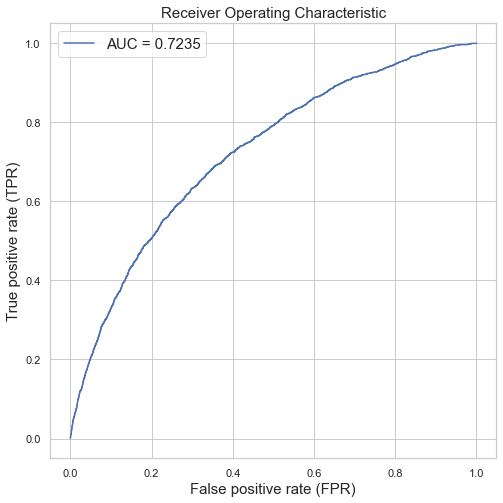

In [699]:
# Отрисовать ROC кривую
y_pred_proba_os = logreg_os.predict_proba(X_valid_os)
calc_and_plot_roc(y_valid_os, y_pred_proba_os[:, 1])

Мы видим, что Over-sampling при помощи SMOTE не улучшил нашу модель в плане роста AUC, но матрица ошибок выглядит чуть лучше

### 3. RFE - рекурсивное устранение признаков для наших данных после Over-sampling

In [700]:
df_train_vars=df_train.columns.values.tolist()
y_col=['default']
X_col=[i for i in df_train_vars if i not in y_col]

In [701]:
X_col

['sex',
 'age',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'income',
 'foreign_passport',
 'April',
 'February',
 'January',
 'March',
 'education_ACD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'work_address_1',
 'home_address_2',
 'home_address_3',
 'sna_1',
 'sna_3',
 'first_time_1',
 'first_time_2',
 'first_time_4',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80']

In [704]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20) # из 32 признаков выберем 20, которые имеют для модели больший вес
rfe = rfe.fit(os_data_X.values, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True  True  True False  True  True  True  True
  True  True  True  True False  True  True False  True  True False False
  True False False False False False  True  True]
[11  8  1  1  1  1  1  6  1  1  1  1  1  1  1  1  5  1  1  3  1  1 12 13
  1 10  4  2  7  9  1  1]


При помощи **RFE** мы выбрали следующие признаки (которые имеют для модели больший вес): 

In [661]:
cols = ['car_type', 'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt', 'foreign_passport', 
        'April', 'February', 'January', 'March', 'education_ACD', 'education_PGR', 'education_SCH',
        'work_address_1', 'home_address_2','sna_1',
        'sna_3', 'first_time_4', 'region_rating_70', 'region_rating_80']

In [662]:
X_train_rfe = X_train_os[cols]
X_valid_rfe = X_valid_os[cols]
y_train_rfe = y_train_os
y_valid_rfe = y_valid_os

In [664]:
X_train_rfe.shape, X_valid_rfe.shape, y_train_rfe.shape, y_valid_rfe.shape

((103112, 20), (14760, 20), (103112,), (14760,))

In [665]:
#Обучаем модель (сделали over-sampling с помощью SMOTE и рекурсивное устранение признаков)
from sklearn.linear_model import LogisticRegression
logreg_os_rfe = LogisticRegression(solver='sag', max_iter=1000, class_weight='balanced', C = 10, 
                            tol = 0.001, random_state = 42, penalty='l2')
logreg_os_rfe.fit(X_train_rfe, y_train_rfe)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='sag', tol=0.001)

In [666]:
y_pred_rfe = logreg_os_rfe.predict(X_valid_rfe)

In [667]:
#Построение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_valid_rfe, y_pred_rfe).ravel()
(tn, fp, fn, tp)

(8896, 3975, 695, 1194)

In [668]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_valid_rfe, y_pred_rfe)
print(classification_report)

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     12871
           1       0.23      0.63      0.34      1889

    accuracy                           0.68     14760
   macro avg       0.58      0.66      0.57     14760
weighted avg       0.84      0.68      0.73     14760



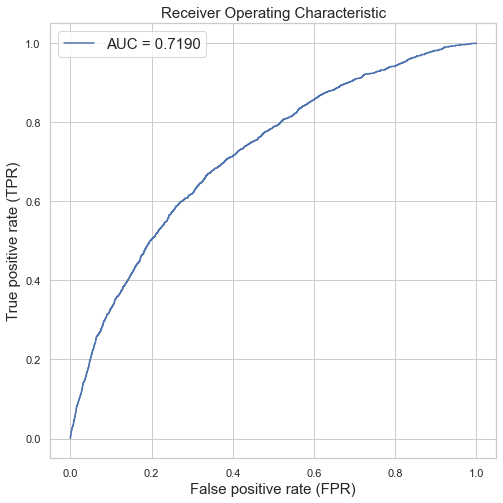

In [669]:
# Отрисовать ROC кривую
y_pred_proba_rfe = logreg_os_rfe.predict_proba(X_valid_rfe)
calc_and_plot_roc(y_valid_rfe, y_pred_proba_rfe[:, 1])

Мы видим, что **RFE** не улучшило нашу модель

### 4. Under-sampling при помощи RandomUnderSampler

In [787]:
#Пробуем применить Undersampling 
X_1 = df_train.loc[:, df_train.columns != 'default']
y_1 = df_train.loc[:, df_train.columns == 'default'].values.ravel()

from imblearn.under_sampling import RandomUnderSampler

random_seed=42

rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_1, y_1)


X_train_us, X_valid_us, y_train_us, y_valid_us = train_test_split(X_us, y_us, test_size=0.20, 
                                                                shuffle = True, random_state=random_seed)

In [788]:
scaler_tr_us = RobustScaler()
# Для обучающей выборки
for column in num_cols:
    X_train_us[column] = scaler_tr_us.fit_transform(np.array(X_train_us[column].values).reshape(-1, 1))
# Для валидационной выборки 
scaler_v_us = RobustScaler()
for column in num_cols:
    X_valid_us[column] = scaler_v_us.fit_transform(np.array(X_valid_us[column].values).reshape(-1, 1))

In [789]:
X_train_us.shape, X_valid_us.shape, y_train_us.shape, y_valid_us.shape

((14995, 32), (3749, 32), (14995,), (3749,))

In [790]:
from sklearn.linear_model import LogisticRegression
logreg_us = LogisticRegression(solver='sag', max_iter=1000, class_weight='balanced', C = 10, 
                            tol = 0.001, random_state = 42, penalty='l2')
logreg_us.fit(X_train_us, y_train_us)

y_pred_us = logreg_us.predict(X_valid_us)

In [791]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_valid_us, y_pred_us)
print(classification_report)

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1887
           1       0.67      0.69      0.68      1862

    accuracy                           0.68      3749
   macro avg       0.68      0.68      0.68      3749
weighted avg       0.68      0.68      0.68      3749



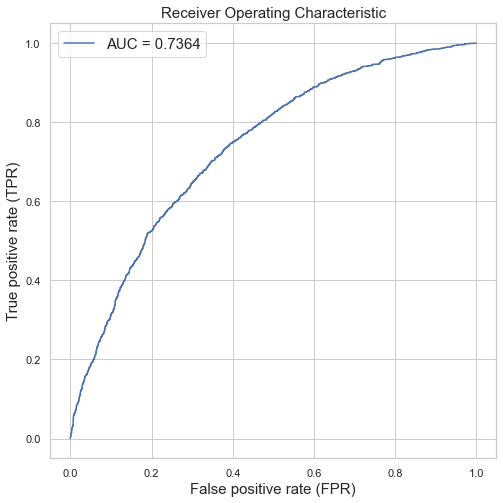

In [792]:
# Отрисовать ROC кривую
y_pred_proba_us = logreg_us.predict_proba(X_valid_us)
calc_and_plot_roc(y_valid_us, y_pred_proba_us[:, 1])

In [793]:
#Построение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_valid_us, y_pred_us).ravel()
(tn, fp, fn, tp)

(1243, 644, 573, 1289)

Улучшилась матрица ошибок, лучше выглядят метрики **recall**, **precision**, **f1-score**.

### Реализация модели

In [794]:
X_final = df_train.loc[:, df_train.columns != 'default']
y_final = df_train.loc[:, df_train.columns == 'default'].values.ravel()
scaler_final = RobustScaler()
# Нормализация для всех данных из датасета train
for column in num_cols:
    X_final[column] = scaler_final.fit_transform(np.array(X_final[column].values).reshape(-1, 1))

In [795]:
# Undersampling
rus_final = RandomUnderSampler(random_state=42)
X_final_us, y_final_us = rus_final.fit_resample(X_final, y_final)

In [796]:
# Обучаем нашу модель на всех данных
from sklearn.linear_model import LogisticRegression
logreg_final = LogisticRegression(solver='sag', max_iter=1000, class_weight='balanced', C = 10, 
                            tol = 0.001, random_state = 42, penalty='l2')
logreg_final.fit(X_final_us, y_final_us)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='sag', tol=0.001)

In [797]:
#Делаем финальное предсказание на основе модели, обученной на данных с undersampling 
predict_submission = logreg_final.predict(df_test)

In [799]:
df_sample_submission['default'] = predict_submission
df_sample_submission.to_csv('submission.csv', index=False)
df_sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [800]:
df_sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.376489
std,31706.052195,0.484512
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


### Резюме

- Анализ данных показал, что данные достаточно чистые. Пропусков немного (в столбце education). Пропуски были заполнены модой.
- Признаки в датасете делятся на бинарные, категориальные и числовые. Бинарные признаки были обработаны с помощью LabelEncoder, категориальные - с помощью OneHotEncoder.
- Для уменьшения размерности и выбросов числовые признаки были прологарифмированы (кроме score_bki). Операция была проведена над объединенным датасетом.
- Числовые признаки впоследствии были нормированы с помощью RobustScaler из библиотеки sklearn, что уменьшило выбросы. Каждый раз нормирование обучающей и валидационной или тестовой выборки проводилось отдельно.
- Столбец с датой был преобразован с помощью OneHotEncoder (получилось 4 новых столбца с месяцами).
- Был проведён корреляционный анализ, в результате которого выяснилась сильная корреляция между некоторыми категориальными признаками, часть из них пришлось удалить (те в паре, кто менее всего коррелировал с искомой переменной default).
- После объединённый датасет был разделён обратно на df_train и df_test. Все поиски подходящей нам модели, поиск оптимальных гиперпараметров модели уже проводился с данными из df_train. 
- В попытке сбалансировать в обучающей выборке интересующую нас переменную default, был применен алгоритм over-sampling SMOTE, создающий синтетические данные. Но это не улучшило метрики нашей модели.
- Была попытка найти признаки, которые имеют для нашей модели больший вес. Это тоже не улучшило модель.
- Помог under-sampling с помощью RandomUnderSampler из библиотеки sklearn, это улучшило метрики